In [0]:
import numpy as np
import torch
import torch.nn as nn
import os
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
from numpy import genfromtxt
import skimage

In [0]:
filname = '/content/drive/My Drive/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('/content/drive/My Drive/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [0]:
def getData(filname):
    # images are 48x48
    # N = 35887
    y = []
    x = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            y.append(int(row[0]))
            x.append([int(p) for p in row[1].split()])

    X, Y = np.array(x) / 255, np.array(y)
    return X, Y

In [0]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [0]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).long()

In [0]:
training_data = []
test_data = []
for i in range(len(X_train)):
    training_data.append([X_train[i], y_train[i]])
for i in range(len(X_test)):
    test_data.append([X_test[i], y_test[i]])

In [0]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2), #kernel_size=11, stride=4, padding=5
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 24x24
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # ! 12x12
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 6x6
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [0]:
net = AlexNet(7)
net = net.cuda()
print(net)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6400, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [0]:
PATH = 'model_filter.h5' # save model at this location after each epoch

EPOCHS = 50

batch_size = 400

train_acc = [0] * EPOCHS

train_loss = [0] * EPOCHS

index = 0

for epochs in range(EPOCHS):
    
    for i in tqdm(range(0, len(X_train), batch_size)):
        
        batch_X = X_train[i:i + batch_size].view(-1, 1, 48, 48).cuda()
        
        batch_y = y_train[i:i + batch_size].cuda()
        
        net.zero_grad()
        
        outputs = net(batch_X)
        
        loss = loss_function(outputs, batch_y)
        
        loss.backward()
        
        optimizer.step()
    
    correct = 0

    total = 0

    net.eval()
    with torch.no_grad():
        for new_i in tqdm(range(0, len(X_test), batch_size)):
            real_class = y_test[new_i:new_i + batch_size]
            batch_X = X_test[new_i:new_i + batch_size].view(-1, 1, 48, 48).cuda()
            ans = net(batch_X)
            for j in range(len(ans)):
                ind = torch.argmax(ans[j])
                if (real_class[j] == ind):
                    correct += 1
                total += 1
    net.train()

    train_acc[index] = round(correct/total, 3)

    train_loss[index] = loss

    index += 1

    print(f"Epoch: {epochs}. Loss: {loss}")

torch.save(net.state_dict(), PATH)

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.43323439359664917


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.36238494515419006


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.43312522768974304


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.3629804253578186


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.33842116594314575


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.3261222541332245


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.31156301498413086


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.3465667963027954


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.355696439743042


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 9. Loss: 0.3064629137516022


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 10. Loss: 0.3411305248737335


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.29851028323173523


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 12. Loss: 0.2613447904586792


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 13. Loss: 0.21855826675891876


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 14. Loss: 0.2112475484609604


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 15. Loss: 0.26162147521972656


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 16. Loss: 0.20759408175945282


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 17. Loss: 0.24441978335380554


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 18. Loss: 0.1758149415254593


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 19. Loss: 0.1773376762866974


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 20. Loss: 0.1900569200515747


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 21. Loss: 0.23560073971748352


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 22. Loss: 0.17373253405094147


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 23. Loss: 0.21139979362487793


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 24. Loss: 0.20359306037425995


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 25. Loss: 0.14738105237483978


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 26. Loss: 0.17860062420368195


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 27. Loss: 0.20196358859539032


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 28. Loss: 0.18379706144332886


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 29. Loss: 0.16944625973701477


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 30. Loss: 0.1778106391429901


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 31. Loss: 0.1647638976573944


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 32. Loss: 0.127301424741745


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 33. Loss: 0.1907506287097931


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 34. Loss: 0.1938363015651703


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 35. Loss: 0.1141946017742157


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 36. Loss: 0.1579795777797699


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 37. Loss: 0.15435229241847992


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 38. Loss: 0.14950580894947052


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 39. Loss: 0.12171418964862823


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 40. Loss: 0.12243488430976868


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 41. Loss: 0.12781712412834167


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 42. Loss: 0.121905617415905


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 43. Loss: 0.1721242517232895


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 44. Loss: 0.10089008510112762


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 45. Loss: 0.07441660761833191


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 46. Loss: 0.09334304928779602


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 47. Loss: 0.10844510048627853


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 48. Loss: 0.11749353259801865


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]

Epoch: 49. Loss: 0.11323826760053635


In [0]:
list1 = [0] * EPOCHS
for i in range(EPOCHS):
  list1[i] = i
len(train_acc)

50

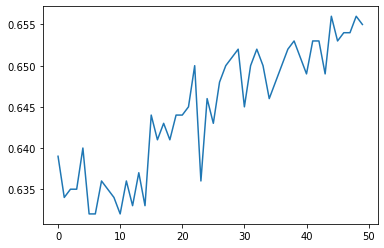

In [0]:
plt.plot(list1, train_acc)
plt.show()

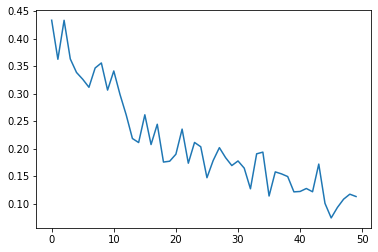

In [0]:
plt.plot(list1, train_loss)
plt.show()